# Transformers

In this notebook, we will be implementing a simple GPT-style decoder-only Transformer. The implementation is inspired by [nanoGPT](https://github.com/karpathy/nanoGPT/tree/master) for the task of next-token prediction. We will use the tiny Shakespeare dataset, which contains everything William Shakespeare has ever written. The implementation is annotated with useful comments and considerations.  

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

## Shakespeare dataset

Download the tiny Shakespeare dataset [here](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt). We can create samples from this text corpus by using a sliding window that scans the entire string with overlapping sequences. Then, we can define the target sequence to be the chosen sequence shifted by one time step. This gives us a way of sampling batches of samples that can be fed to the Transformer model. Note that the sequence length will be fixed, since the Transformer is a sequence to sequence model (seq2seq). At the beginning, individual characters are transformed into integer representations. For this, we maintain two dictionaries: one that encodes characters into integers, and another that converts integers back into characters. 

In [2]:
from torch.utils.data import DataLoader, Dataset

class VocabDataset(Dataset):
    def __init__(self, file_patch: str, seq_len: int):
        f = open(file_patch, 'r')
        corpus = f.read()
        f.close()
        self.seq_len = seq_len
        self.vocab = sorted(list(set(corpus)))
        self.vocab_size = len(self.vocab)
        self.stoi = dict(zip(self.vocab, range(self.vocab_size)))

        self.encoder = lambda c: [self.stoi[ci] for ci in c]
        self.decoder = lambda x: [self.vocab[xi] for xi in x]
        self.data = torch.tensor(self.encoder(corpus))

    def __getitem__(self, index):
        x = self.data[index: index + self.seq_len]
        y = self.data[index+1: index + self.seq_len+1]
        return x, y

    def __len__(self):
        return len(self.data) - self.seq_len

In [3]:
dataset = VocabDataset("../datasets/shakespeare.txt", seq_len=8)

print(f"length of dataset in characters: {len(dataset.data):,}")

# get all the unique characters that occur in this text
print("all the unique characters:", ''.join(dataset.vocab))
print(f"vocab size: {dataset.vocab_size:,}")

length of dataset in characters: 1,115,389
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65


In [4]:
loader = DataLoader(dataset, batch_size=4, shuffle=False)

##############################
### take the first batch from loader and print its (x, y) values
### also decode the values to obtain character representations and print these
### write code here
##############################

batch x shape: torch.Size([4, 8])
batch y shape: torch.Size([4, 8])
batch sample 0: x=[First Ci]	 y=[irst Cit]
                x=[tensor([18, 47, 56, 57, 58,  1, 15, 47])]	 y=[tensor([47, 56, 57, 58,  1, 15, 47, 58])]
batch sample 1: x=[irst Cit]	 y=[rst Citi]
                x=[tensor([47, 56, 57, 58,  1, 15, 47, 58])]	 y=[tensor([56, 57, 58,  1, 15, 47, 58, 47])]
batch sample 2: x=[rst Citi]	 y=[st Citiz]
                x=[tensor([56, 57, 58,  1, 15, 47, 58, 47])]	 y=[tensor([57, 58,  1, 15, 47, 58, 47, 64])]
batch sample 3: x=[st Citiz]	 y=[t Citize]
                x=[tensor([57, 58,  1, 15, 47, 58, 47, 64])]	 y=[tensor([58,  1, 15, 47, 58, 47, 64, 43])]


## Transformer modules

For the task of **autoregressive prediction**, we can use a so-called **decoder-only Transformer**. Autoregressive prediction simply means that we predict the next token based on a sequence of tokens, and then append the prediction to the end of our input sequence, and make the next prediction. This way, we can keep generating text indefinitely, but at some point the generated text might not be very coherent. 

The **Transformer** can be seen as a collection of modules that form a pipeline to transform one sequence of data into another sequence of data. In the image below, the inputs come in from the bottom and are subject to the following transformation steps:
1. **Token embedding** in which the tokens are transformed from integers (representing characters) to learnable vectors of $d$ dimensions
2. **Positional encoding** in which a positional encoding is added to the token embeddings, so that the model is aware of the order of the tokens in the sequence
3. **Transformer block** in which we apply several transformations one after the other: 
    - Multi-head Attention mechanism
    - Position-wise feedforward network
4. **Linear layer** to transform the dimensionality of the sequence back to the output dimensionality
5. **Softmax** to normalize the outputs so that it represents a probability distribution

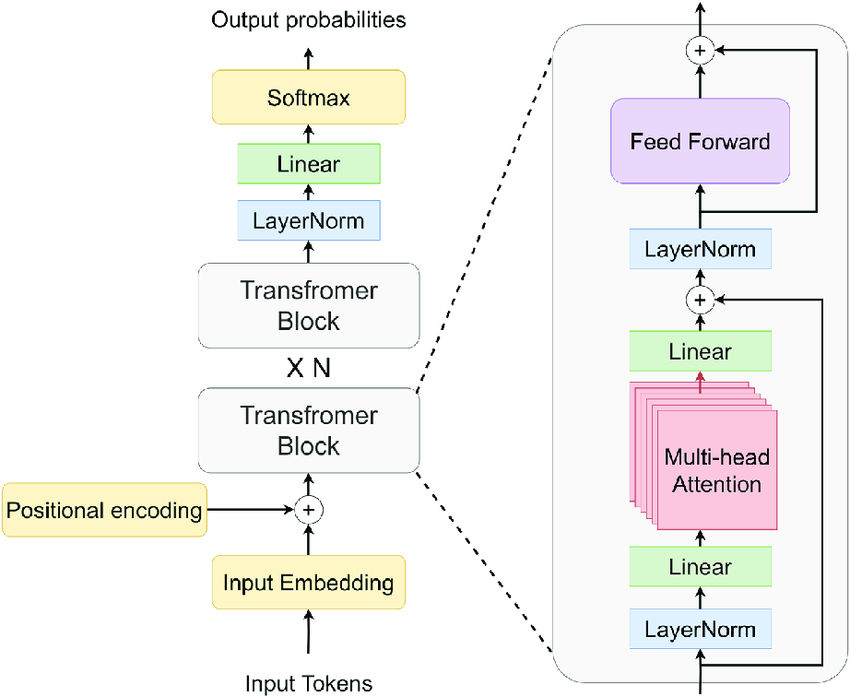

### Embedding and Positional Encoding

The first step is to embed our input sequence. Recall that our sequence of characters is first encoded as a sequence of integers. We then need to embed this integer sequence via linear projection or via a lookup table. Using `nn.Embedding`, a lookup table is created that we can learn via backpropagation. Simply using integers as the embedding will not suffice because we often need more than 1 dimension to the represent the semantic meaning of tokens, and it is difficult to come up with such an encoding ourselves. Therefore, we instead learn a proper encoding directly from the data. 

As a side-note, tokens can be regarded as anything in a sequential form. For example, a video consists of a sequence of images, which we can define as tokens. Or a book consists of a sequence of words that we can regard as tokens. In our running example, a string is a sequence of characters that we regard as tokens. 

Once we have embedded our sequence via a learnable lookup table (`nn.Embedding`) or a linear transformation (`nn.Linear`), we need to add positional information to the sequence. The original paper on Transformers called "Attention Is All You Need" (2017) provides a simple positional encoding scheme based on sine and cosine patterns. Alternative options include using a second `nn.Embedding` or `nn.Linear` layer to learn positional encodings. However, often applying a simple scheme does the trick as well. 

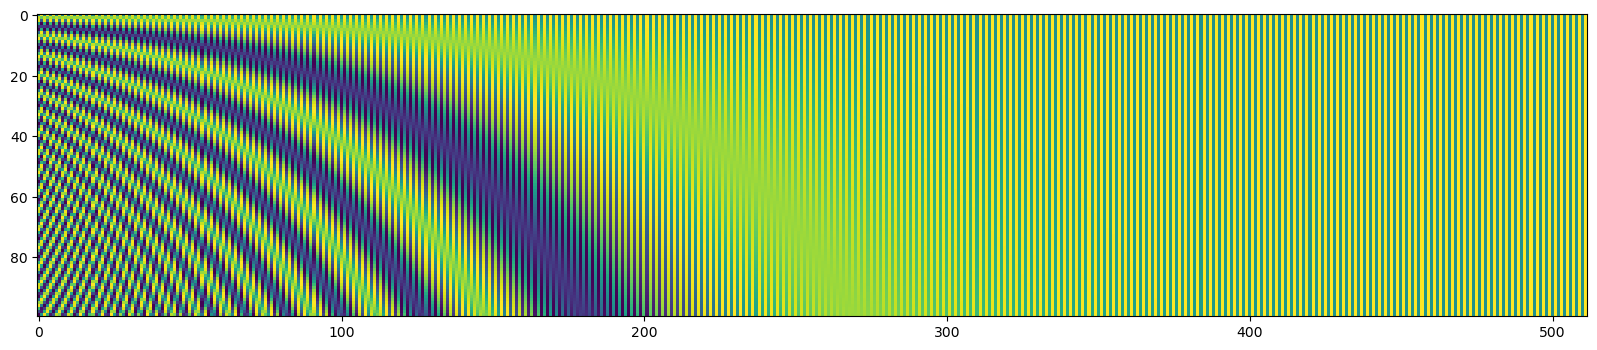

In [5]:
import math

"""
Standard positional encoding layer adopted from "Attention Is All You Need"
"""
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)
    
enc = PositionalEncoding(d_model=512, max_len=100)
plt.figure(figsize=(20, 5))
plt.imshow(enc.pe.squeeze())

### Attention mechanism

One of the fundamental ideas introduced by the Transformer is the use of the Attention mechanism. The analogy here is taken from the information retrieval literature. Consider a database of information $\mathcal{D}$, we want to search through the database and obtain information. We formulate a query $\mathbf{Q}$, which specifies exactly which information we want to look for in $\mathcal{D}$. Furthermore, the database $\mathcal{D}$ can be decomposed into two components; the keys $\mathbf{K}$ and the values $\mathbf{V}$. Both keys and values are related to each other. We can look for a certain key in $\mathbf{K}$ and then take the values corresponding to this key from $\mathbf{V}$. In Python you could implement this as a dictionary.

In [6]:
# we want to query the value of x
query = "x"

# our database is a simple dictionary of keys and values
database = {
    "x": "Hello, world!",
    "y": "Discussion group lecture of week 8",
    "z": "Minor AI"
}

# obtain value based on query
database[query]

'Hello, world!'

Let's now create a different encoding and try to perform this same query again. We define our dictionary database as two arrays, which we call `keys` and `values`. The `keys` are a one-hot encoding of the keys in the original Python dictionary. Since we had 3 distinct keys ("x", "y", and "z"), we get 3 lists, each containing all zeros except for one distinct value being a one. Naturally, our query will also be a one-hot encoding corresponding to one of the keys. Then, we define the values as a matrix containing 3 rows with each row having an integer encoding of the original strings in the dictionary. This way everything is numerically encoded. 

In [7]:
# one-hot encoding
query = np.array([1, 0, 0])
keys = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

# label-encoding
max_token = len(max(database.values(), key=lambda x: len(x)))
values = np.array([
    [ord(c) for c in list(val) + ([' '] * (max_token - len(val)))] 
    for val in database.values()
])

query, keys, values

(array([1, 0, 0]),
 array([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]),
 array([[ 72, 101, 108, 108, 111,  44,  32, 119, 111, 114, 108, 100,  33,
          32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
          32,  32,  32,  32,  32,  32,  32,  32],
        [ 68, 105, 115,  99, 117, 115, 115, 105, 111, 110,  32, 103, 114,
         111, 117, 112,  32, 108, 101,  99, 116, 117, 114, 101,  32, 111,
         102,  32, 119, 101, 101, 107,  32,  56],
        [ 77, 105, 110, 111, 114,  32,  65,  73,  32,  32,  32,  32,  32,
          32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
          32,  32,  32,  32,  32,  32,  32,  32]]))

The numerical query operation proceeds as follows:

We take the dot product, i.e., weighted sum, between each key $\mathbf{k}_i \in \mathbf{K}$ and some query $\mathbf{q}$
$$
    \mathbf{k}_i \cdot \mathbf{q} = \sum_{j=1}^d k_{ij}q_j, \qquad \forall \mathbf{k}_i \in \mathbf{K}
$$

This operation can also be seen as a matrix-vector product between all keys $\textbf{K}$ and the query vector $\textbf{q}$:
\begin{align*}
    \textbf{K} \cdot \textbf{q} &= \underbrace{\begin{bmatrix} 
        k_{11} & k_{12} & \dots & k_{1d} \\
        k_{21} & k_{22} & \dots & k_{2d} \\
        \vdots & \vdots & \ddots & \vdots \\
        k_{N1} & k_{N2} & \dots & k_{Nd} \\
    \end{bmatrix} \cdot \begin{bmatrix} q_1 \\ q_2 \\ \vdots \\ q_d \end{bmatrix}}_{\text{matrix-vector product}}\\
\end{align*}

Visualisation: http://matrixmultiplication.xyz/

Often, we normalize the result $\textbf{K} \cdot \textbf{q}$ in every row of the matrix such that the sum of each row equals 1. In other words, we apply a softmax to the rows of the resulting matrix. In this case, it is not needed, because we used a manual encoding.

In the same way, we can apply a matrix-matrix product between $\textbf{K} \cdot \textbf{q}$ and $\textbf{V}$, which means that we retrieve the correct values from the query-key product based on $\textbf{q}$.

$$
    (\textbf{K} \cdot \textbf{q}) \textbf{V}
$$

In [8]:
out = (keys @ query) @ values
out_str = ''.join([chr(i) for i in out]).strip()
out, out_str

(array([ 72, 101, 108, 108, 111,  44,  32, 119, 111, 114, 108, 100,  33,
         32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
         32,  32,  32,  32,  32,  32,  32,  32]),
 'Hello, world!')

Of course, this only works for this hand picked example. You can also see this procedure as a *hard* way of querying correct and precise information. Often, however, we do not have precise information when we try to learn a model (due to inevitable noise in the data). The more general formula for attention is the following. 
$$
\text{Attention}(\textbf{Q}, \textbf{K}, \textbf{V}) = \text{softmax}\left(\dfrac{\textbf{Q}\textbf{K}^T}{\sqrt{d}}\right) \textbf{V}
$$

where we apply the same operations as before. Note that $\mathbf{K}^T$ is just $\mathbf{K}$ transposed, i.e., each $\mathbf{K}_{ij}$ become $\mathbf{K}_{ji}$, or we simply switch the rows for the columns. Also notice that we now divide by $\sqrt{d}$, which ensures that the result of $\textbf{Q}\textbf{K}^T$ has unit variance given that both $\textbf{Q}$ and $\textbf{K}^T$ have zero mean and unit variance. 

You might wonder now how this relates to our existing problem and where those $\mathbf{Q}, \mathbf{K}, \mathbf{V}$ matrices came from. Well, this is where **self-attention** and **cross-attention** come into play. In self-attention, we have a given input matrix $\mathbf{X}$, which consists of a sequence of data where each time point is a vector of values. We simply apply 3 different linear transformations (i.e., dot products) to $\mathbf{X}$ to obtain $\mathbf{Q}, \mathbf{K}, \mathbf{V}$. 
\begin{align*}
    \mathbf{Q} &= \mathbf{W}_Q \mathbf{X}\\
    \mathbf{K} &= \mathbf{W}_K \mathbf{X}\\
    \mathbf{V} &= \mathbf{W}_V \mathbf{X}\\
\end{align*}
where $\mathbf{W}_Q, \mathbf{W}_K, \mathbf{W}_V$ are the weight matrices of the `nn.Linear` layers. Therefore, in self-attention we attend to $\mathbf{X}$ itself via
$$
\text{Attention}(\mathbf{W}_Q \mathbf{X}, \;\;\mathbf{W}_K \mathbf{X}, \;\;\mathbf{W}_V \mathbf{X})
$$
Or in other words, given a sequence, attention calculates how important each time point in the sequence is for the task of prediction. We can also regard the attention weights as importance weights that give us some degree of belief that certain elements in the sequence are more important than others, and thus, should be attended to. 

One last topic to consider is that we often mask our attention weights, so that current time points do not attend to future time points. This attention mask should simply be a diagonal matrix with ones in the lower triangular section of the mask and zeros in the upper triangular section of the mask. 

In [9]:
"""
Standard Scaled Dot product attention mechanism
"""
class DotProductAttention(nn.Module):

    def __init__(self, dropout_rate: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.attention_weight = torch.Tensor(0)

    def forward(self, query: torch.Tensor, keys: torch.Tensor, vals: torch.Tensor, mask: torch.Tensor = None):
        # query/keys: (batch_size, n_heads, seq_len, n_hidden/n_heads)
        # vals:       (batch_size, n_heads, seq_len, n_hidden/n_heads)
        d = query.shape[-1]
        
        ##############################
        ### apply the matrix multiplication between query and the transpose of keys (divided by square root of d)
        ### name the result "presoftmax"
        ### hint: the resulting shape should be (batch_size, n_heads, seq_len, seq_len)
        ### write code here
        ##############################
        presoftmax = None
        
        if mask is not None:
            presoftmax = presoftmax.masked_fill(mask == 0, float('-inf'))

        self.attention_weight = F.softmax(presoftmax, dim=-1)
        self.attention_weight = self.dropout(self.attention_weight)
        
        # output: (batch_size, n_heads, seq_len, n_hidden/n_heads)
        return self.attention_weight @ vals, self.attention_weight

In [25]:
attn = DotProductAttention()

q = torch.randn(32, 8, 4)
k = torch.randn(32, 8, 4)
v = torch.randn(32, 8, 4)

# return both output as well as attention weights for visualization purposes
out, attn_weights = attn(q, k, v)

out.shape, attn_weights.shape

(torch.Size([32, 8, 4]), torch.Size([32, 8, 8]))

### Multi-head attention

Having a single `DotProductAttention` will ensure that we learn to recognize attention patterns in one single way. Often prediction problems in NLP show complex interdependencies between tokens, such that we will need several of these attention "heads" (or modules) to compute different patterns that arise. We can regard each attention head as an entity that has a vote on what parts of the past sequence are important for the prediction of the future sequence. This democratic process can of course be aggregated in the same way we humans use voting schemes to aggregate votes for representative party leaders. This is the main idea of Multi-head attention. We simply apply multiple attention modules in parallel and aggregate each output in some way. The usual and easiest way of aggregating the attention outputs is by linear transformation. 

In the implementation below, we reshape the key, query, and values matrices in such a way that we can apply the attention mechanism once, and have it compute attention for all attention heads in a single processing step. The reshaping takes the following steps:
1. Input keys, queries, values come in as `(batch_size, seq_len, emb_size)`
2. Linearly transform these so that their shapes are `(batch_size, seq_len, n_hidden)`
3. Reshape these so that their shapes are `(batch_size, seq_len, n_heads, n_hidden / n_heads)`. Note that we introduce a 4th dimension for the heads.
4. Permute the order of the dimensions so that their shapes are `(batch_size, n_heads, seq_len, n_hidden / n_heads)`
5. Apply attention and get the same shape back `(batch_size, n_heads, seq_len, n_hidden / n_heads)`
6. Reshape so that shape becomes `(batch_size, seq_len, n_hidden * n_heads)`
7. Linearly transform so that we go back to `emb_size` dimensions instead of `n_hidden * n_heads` dimensions, i.e., we get `(batch_size, seq_len, emb_size)`

This trick to reduce computation can only be applied if `n_hidden` can be divided by `n_heads`.  

In [26]:
"""
Multi-head attention mechanism.
"""
class MultiHeadAttention(nn.Module):

    def __init__(
        self, attention: nn.Module, n_heads: int, n_hidden: int, n_out: int, bias=False
    ):
        super().__init__()
        self.n_heads = n_heads
        self.n_hidden = n_hidden
        ##############################
        ### define 4 lazy linear layers: W_q, W_k, W_v, W_o
        ### these should transform input to have n_hidden dimensions
        ### use the bias flag to give W_q, W_k, W_v a bias based on provided argument
        ### W_o should always have a bias
        ### write code here
        ##############################
        self.W_q = None
        self.W_k = None
        self.W_v = None
        self.W_o = None
        
        self.attention = attention
        self.attn_weights = torch.Tensor(0)

    def transpose_QKV(self, X: torch.Tensor):
        X = X.reshape(*X.shape[:2], self.n_heads, -1)
        X = X.permute(0, 2, 1, 3)  # (batch_size, n_heads, seq_len, n_hidden/n_heads)
        return X

    def forward(
        self,
        queries: torch.Tensor,
        keys: torch.Tensor,
        values: torch.Tensor,
        mask: torch.Tensor = None,
    ):
        # input: queries, keys, values have shape (batch_size, seq_len, emb_size)
        
        K = self.transpose_QKV(self.W_k(keys))
        V = self.transpose_QKV(self.W_v(values))
        Q = self.transpose_QKV(self.W_q(queries))
        # Q, K, V: (batch_size, n_heads, seq_len, n_hidden/n_heads)

        out, self.attn_weights = self.attention(Q, K, V, mask)
        out = out.reshape(
            out.shape[0], out.shape[2], -1
        )  # (batch_size, seq_len, n_hidden*n_heads)

        return self.W_o(out)
    
mha = MultiHeadAttention(DotProductAttention(), 4, 64, 20)

x = torch.randn(32, 8, 20)
mha(x, x, x).shape

c:\Users\janba\anaconda3\envs\workspace_jan\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([32, 8, 20])

### Position-wise feedforward network

After obtaining the output of the Multi-head attention module, a simple feedforward network is applied which has a single hidden layer and an output layer, with some activation function (usually ReLU) in between. 

In [27]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_n_hidden, ffn_n_outputs):
        super().__init__()
        
        ##############################
        ### define a simple FFN using `nn.LazyLinear` layers
        ### dense1 should output ffn_n_hidden dimensions
        ### dense2 should output ffn_n_output dimensions
        ### write code here
        ##############################
        self.dense1 = None
        self.dense2 = None
        
        self.relu = nn.ReLU()
        
    def forward(self, X: torch.Tensor):
        return self.dense2(self.relu(self.dense1(X)))

ffn = PositionWiseFFN(4, 8)
x = torch.randn(32, 3, 4)
ffn(x).shape

torch.Size([32, 3, 8])

### Single Transformer Block

Now that we have the Multi-head attention module and the position-wise feedforward network, we can combine them to get a single Transformer block. You might think that just performing multi-head attention on the inputs and thereafter processing the input via the feedforward network would be a good strategy. However, when networks like the Transformer become larger and deeper, the training process can become unstable. As we have seen with Recurrent Neural Networks, the further the gradients have to travel, the smaller (vanishing) or larger (exploding) they become. The same applies here when we use multiple Transformer blocks. Therefore, a solution is to use so-called **residual** (or skip) connections. In essence, given an input $X$, we apply some submodule of the network $f(X)$ and add the result to $X$. 
$$
    Y = X + f(X)
$$
This way the gradient can always travel via a direct path from $Y$ to $X$, regardless of the gradient calculation in $f(X)$. Residual connections are an important concept that you can apply to many Neural Networks to ensure more stable training when the networks become deeper. 

Another important aspect that we apply is **layer normalization**, which ensures that the activations are normalized. Note that using layer norm introduces two new variables $\bm{\mu}$ and $\bm{\sigma}$ that are learned during training. 

In the original Transformer paper "Attention Is All You Need", the authors apply a residual connection and layer normalization once right after multi-head attention, and once more after the feedforward network. In recent work, it seems that Transformers obtain better performance when the layer norm is applied before the multi-head attention module and before the feedforward network. In the following, we implement the Transformer block that consists of the `MultiHeadAttention` module, `PositionWiseFFN` module, and two `nn.LayerNorm` modules. Based on a boolean flag `norm_first`, we can apply either layer norm prior to the submodules or after the submodules.  

In [28]:
class TransformerBlock(nn.Module):
    def __init__(
        self,
        n_heads: int=8,
        n_hidden: int=64,
        n_out: int=512,
        ffn_n_hidden: int=2048,
        _attention: nn.Module=DotProductAttention(),
        dropout: float=0.1,
        norm_first: bool=True
    ):
        """
        :param n_heads: number of attention heads
        :param n_hidden: dimensionality of each attention head
        :param n_out: dimensionality of output (after multi-head attention and after point-wise feedforward network)
        :param ffn_n_hidden: hidden dimension of feedforward network
        :param _attention: self attention module (default: DotProductAttention)
        :param dropout: dropout rate
        :param norm_first: whether to apply layer normalization before attention layer or after
        """
        super().__init__()
        self.norm_first = norm_first
        self.mha = MultiHeadAttention(_attention, n_heads, n_hidden, n_out)
        self.ffn = PositionWiseFFN(ffn_n_hidden, n_out)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm1 = nn.LayerNorm(n_out)
        self.layer_norm2 = nn.LayerNorm(n_out)
        
    def forward(self, X: torch.Tensor, mask: torch.Tensor = None):
        
        if self.norm_first:
            X = self.layer_norm1(X)
            X = X + self.mha(X, X, X, mask)
            X = self.layer_norm2(X)
            X = X + self.ffn(X)
        else:
            X = self.layer_norm1(X + self.mha(X, X, X, mask))
            X = self.layer_norm2(X + self.ffn(X))

        return self.dropout(X)

tb = TransformerBlock()
x = torch.randn(32, 8, 512)
tb(x).shape

torch.Size([32, 8, 512])

### Stack of Transformer Blocks

The next step is to stack multiple Transformer blocks and include the embedding layer and output layer. As discussed, since we are working with a fixed vocabulary of tokens, we apply `nn.Embedding`, which is a simple learnable lookup table. If the inputs were not text nor had fixed amount of possible values, we could have used `nn.Linear` instead. After applying the Transformer blocks in sequence, we need to create an output of appropriate dimensionality. In this case, the outputs should have the same size as the vocabulary size, so that we can sample from this by regarding it as a probability distribution.   

In [29]:
import copy

class DecoderOnlyTransformer(nn.Module):

    def __init__(
        self,
        vocab_size: int,
        emb_size: int=512,
        n_heads: int=8,
        n_hidden: int=64,
        ffn_n_hidden: int=2048,
        num_layers: int=3,
        _attention: nn.Module=DotProductAttention()
    ):
        """
        :param vocab_size: number of possible input tokens
        :param emb_size: embedding size of d_in (d_model)
        :param n_heads: number of heads in multi-head attention
        :param n_hidden: number of units in Query, Key, Value projection in multi-head attention
        :param ffn_n_hidden: number of hidden units in point-wise FFN
        :param num_layers: number of attention decoder layers
        :param _attention: attention module (default: DotProductAttention)
        """
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.pos_enc = PositionalEncoding(emb_size)

        decoder_block = TransformerBlock(
            n_heads=n_heads,
            n_hidden=n_hidden,
            n_out=emb_size,
            ffn_n_hidden=ffn_n_hidden,
            _attention=_attention
        )
        self.transformer_blocks = nn.ModuleList(
            [copy.deepcopy(decoder_block) for _ in range(num_layers)]
        )
        self.output_layer = nn.LazyLinear(vocab_size)

    def forward(self, X: torch.Tensor, mask: torch.Tensor = None):
        # shape X:  (batch_size, seq_len, 1)
        
        # embedding + positional encoding: (batch_size, seq_len, 1) -> (batch_size, seq_len, emb_size)
        X = self.pos_enc(self.emb(X))

        # Update X through decoder blocks with mask of shape: (seq_len, seq_len)
        for block in self.transformer_blocks:
            X = block(X, mask=mask)

        # output shape: (batch_size, seq_len, vocab_size)
        return self.output_layer(X)

## Test on Shakespeare dataset

In [30]:
# Training constants
EPOCHS = 40
BATCH_SIZE = 256
LEARNING_RATE = 0.001
LEARNING_RATE_GAMMA = 0.9

SEQ_LEN = 32

# Model constants
EMB_SIZE = 128
N_HEADS = 4
N_HIDDEN = EMB_SIZE // N_HEADS
FFN_N_HIDDEN = 4 * EMB_SIZE
NUM_LAYERS = 4

# check for possible GPU usage
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Dataset preparation

We define the dataset, and split it into train/test/validation splits according to 0.8/0.1/0.1 distribution

In [36]:
dataset = VocabDataset("../datasets/shakespeare.txt", seq_len=SEQ_LEN)

# split dataset
train_indices = list(range(0, int(len(dataset) * 0.8)))
val_indices = list(range(int(len(dataset) * 0.8), int(len(dataset) * 0.9)))
test_indices = list(range(int(len(dataset) * 0.9), len(dataset)))

# index dataset using splits
train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

# create dataloaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(val_loader), len(test_loader)

(3486, 436, 436)

### Create mask 

Since we defined our dataset to yield sequences of the form $[x^{(t)}, x^{(t+1)}, \dots, x^{(T)}]$ with target sequences of the form $[x^{(t+1)}, x^{(t+2)}, \dots, x^{(T+1)}]$, what we are really aiming to do is for each time point $x^{(t)}$ try to predict the immediate next time point $x^{(t+1)}$. This of course means that we need to provide a mask to the attention mechanism so that it does not attend to future time points, because that would be cheating.

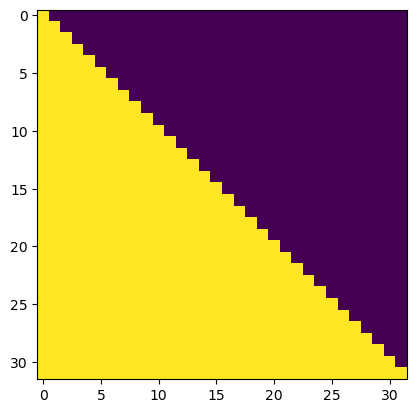

In [34]:
mask = torch.tril(torch.ones((SEQ_LEN, SEQ_LEN)), diagonal=0).to(DEVICE)

plt.imshow(mask.cpu())

### Create model

We define our model, an optimizer, a learning rate scheduler, and some lists to monitor training loss

In [33]:
model = DecoderOnlyTransformer(
    vocab_size=dataset.vocab_size,
    emb_size=EMB_SIZE,
    n_heads=N_HEADS,
    n_hidden=N_HIDDEN,
    ffn_n_hidden=FFN_N_HIDDEN,
    num_layers=NUM_LAYERS
).to(DEVICE)

optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=LEARNING_RATE_GAMMA)

train_history = []
val_history = []

### Training loop

The training loop should be familiar. One thing to note is that we output logits instead of probabilities, because this can be numerically unstable for the `F.cross_entropy` function.  

In [34]:
for epoch in range(EPOCHS):
    
    batch_losses = []
    for i, (batch_x, batch_y) in enumerate(train_loader):
        
        batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)

        y_pred = model(batch_x, mask)
        y_pred = y_pred.transpose(1, 2)

        loss = F.cross_entropy(y_pred, batch_y)
        batch_losses.append(loss.item())
        
        optim.zero_grad()
        loss.backward()
        optim.step()

    scheduler.step()

    train_history.append(torch.mean(torch.tensor(batch_losses)))

    batch_losses = []
    with torch.no_grad():
        for i, (batch_x, batch_y) in enumerate(val_loader):
            batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)

            y_pred = model(batch_x, mask)
            y_pred = y_pred.transpose(1, 2)
            
            loss = F.cross_entropy(y_pred, batch_y)
            batch_losses.append(loss.item())

    val_history.append(torch.mean(torch.tensor(batch_losses)))
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")


epoch 0, train_loss 0.7447284460067749, val_loss 0.1788812279701233
epoch 1, train_loss 0.1156906858086586, val_loss 0.10041501373052597
epoch 2, train_loss 0.08664868026971817, val_loss 0.08472037315368652
epoch 3, train_loss 0.0772118791937828, val_loss 0.08302180469036102
epoch 4, train_loss 0.07223279029130936, val_loss 0.07439396530389786
epoch 5, train_loss 0.06845282018184662, val_loss 0.06980004161596298
epoch 6, train_loss 0.06597352027893066, val_loss 0.06908293813467026
epoch 7, train_loss 0.06394360214471817, val_loss 0.0663415938615799
epoch 8, train_loss 0.06230559200048447, val_loss 0.06536637991666794
epoch 9, train_loss 0.06096174195408821, val_loss 0.06413397192955017
epoch 10, train_loss 0.05995503067970276, val_loss 0.06332303583621979
epoch 11, train_loss 0.05895409733057022, val_loss 0.06220311298966408
epoch 12, train_loss 0.05812590941786766, val_loss 0.06136467307806015
epoch 13, train_loss 0.057407524436712265, val_loss 0.06093534082174301
epoch 14, train_loss

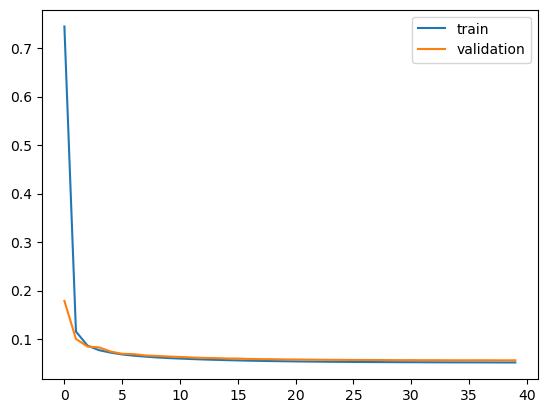

In [35]:
plt.plot(train_history, label='train')
plt.plot(val_history, label='validation')
plt.legend()
plt.show()

### Save and load model

Training takes a long time so you might want to serialize and deserialize the model for later use

In [36]:
torch.save(model, '../datasets/shakespeare_model.pkl')

In [37]:
model = torch.load('../datasets/shakespeare_model.pkl', map_location=DEVICE)

### Perform inference

To apply inference with our learned model, we need to understand the input/output relation of our model. In essence, given a sequence of values $[x^{(t)}, x^{(t+1)}, \dots, x^{(T)}]$, the decoder-only Transformer outputs
$$
    [x^{(t+1)}, x^{(t+2)}, \dots, x^{(T+1)}] = \text{Transformer}([x^{(t)}, x^{(t+1)}, \dots, x^{(T)}])
$$
which means that only the very last element of the output $x^{(T+1)}$ is relevant for inference (i.e., next-token prediction). So we take $x^{(T+1)}$ and append it to our existing sequence. For the next inference step, we take the last `seq_len` values from the sequence and predict the next token $x^{(T+2)}$. This repeats until we are satisfied with the prediction length.  

In [46]:
max_new_tokens = 200

# take first sample from test set
idx, _ = test_set[0]
idx = idx.unsqueeze(0).to(DEVICE) # (1, seq_len)

for _ in range(max_new_tokens):
    
    # crop idx to the last seq_len tokens
    idx_cond = idx[:, -SEQ_LEN:]

    # get the predictions (1, seq_len, vocab_size)
    logits = model(idx_cond, mask)

    # focus only on the last time step
    logits = logits[:, -1, :] # becomes (1, vocab_size)
    
    # apply softmax to get probabilities
    probs = F.softmax(logits, dim=-1) # (1, vocab_size)
    
    # sample from the distribution
    idx_next = torch.multinomial(probs, num_samples=1) # (1, 1)

    # append sampled index to the running sequence
    idx = torch.cat((idx, idx_next), dim=1) # (1, seq_len+1)

# decode predictions
print(''.join(dataset.decoder(idx.squeeze().tolist())))

eved as I?
But who comes here?

LEONTES:
As hide than I have some you eard
so.

LEONTES:
I thing prosinn on for there it.

LEONTES:
Come I'll have not thou lo siins
Tobe:
Peace; still away
You, an know.

PENVOLI:
Now since; not, for
